In [4]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from scipy.special import sinc
plt.rcParams["figure.facecolor"] = "white"

def quad(func:callable, xq: np.array, wq: np.array):
    """ 
    Gauss quadrature
    xq: array of quadrature points
    wq: array of quadrature weights
    """
    s = 0
    for xq_j, wq_j in zip(xq,wq):
        s += wq_j*func(xq_j)
    return s

# sine DVR
Let $\psi_n(z) = \sqrt{\frac{2}{L}}\sin(\frac{n\pi}{L}(z-x_0)), n=1,\cdots,N$ be the orthorgonal functions on $[x_0,L]$. Then the "coordinate basis" functions is given by

$$ u_j(z) = w_j\sum_{n=1}^N \psi_n(z)\psi_n^*(z_j) $$

where $w_j$ is the j-th weight for the selected quadrature rule and $u_j$ satisfy the Kronecker delta property
$$ u_j(x_k) = \delta_{jk} $$

Now the solution becomes
$$ \xi(z) = \sum_{n=1}^{N} a_n u_n(z) $$

Text(0.5, 1.0, '$ \\int_0^\\pi u_i(x)u_j(x) $')

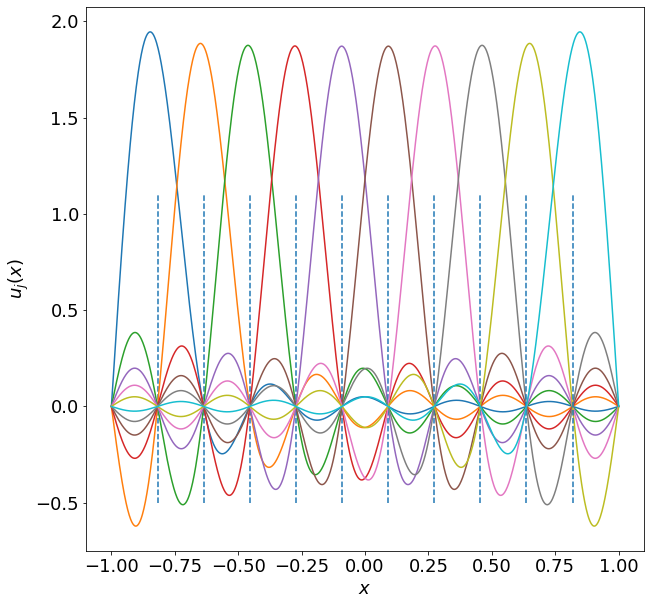

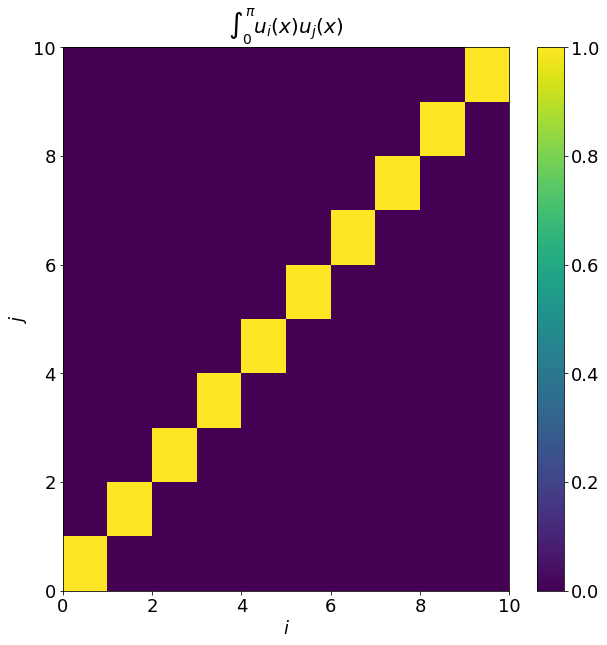

In [37]:
N = 10
L = 2
x0 = -1

xq = np.arange(1,N+1)*L/(N+1) + x0  # quadrature points
wq = np.pi/(N+1)*np.ones_like(xq) # quadrature weights
psi = lambda x,n: np.sqrt(2/L)*np.sin(n*np.pi/L*(x-x0))
psi_p = lambda x,n: np.sqrt(2/L)*n*np.pi/L*np.cos(n*np.pi/L*(x-x0)) 

def unnomalized_u(x,j):
    s = 0
    for n in range(N+1):
        s += psi(x,n)*psi(xq[j],n)
    return wq[j]*s

c = quad(lambda x: unnomalized_u(x,0)*unnomalized_u(x,0), xq,wq)
def u(x,j):
    return unnomalized_u(x,j)/np.sqrt(c)

def u_p(x,j):
    s = 0
    for n in range(N+1):
        s += psi_p(x,n)*psi(xq[j],n)/np.sqrt(c)
    return wq[j]*s


plt.figure()
x = np.linspace(x0,x0+L,1000)
for j in range(N):
    plt.plot(x, u(x,j))
    plt.vlines(xq[j], -0.5,1.1,linestyles='--')
plt.ylabel("$u_j(x)$")
plt.xlabel("$x$")

plt.figure()
integrals = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        integrals[i,j] = quad(lambda x: u(x,i)*u(x,j), xq, wq)
plt.pcolormesh(integrals)
plt.colorbar()
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.title("$ \int_0^\pi u_i(x)u_j(x) $")

In [38]:
v0 = 1.5
O = np.zeros((N,N), dtype=complex)
I = np.eye(N,dtype=complex)
A21 = np.zeros((N,N), dtype=complex)
A22 = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        A21[i,j] = (1-v0**2)*quad(lambda x: u_p(x,i)*u_p(x,j),xq,wq)
        A22[i,j] = 2j*v0*quad(lambda x: u(x,i)*u_p(x,j),xq,wq)

[ 0.85798975+3.13695009e-14j  2.20640221+1.12029236e-01j
  2.20640221-1.12029236e-01j  4.12186611-2.03839305e-14j
  6.10199077+4.00256559e-14j  6.40703697-3.25105888e-14j
 10.96429002-3.33586250e-14j 16.66259103+1.86995018e-14j
 23.7660096 -1.69217192e-14j 31.42299286+4.81112546e-14j]
[ 0.          1.96349541  3.92699082  5.89048623  7.85398163  9.81747704
 11.78097245 13.74446786 15.70796327 17.67145868]


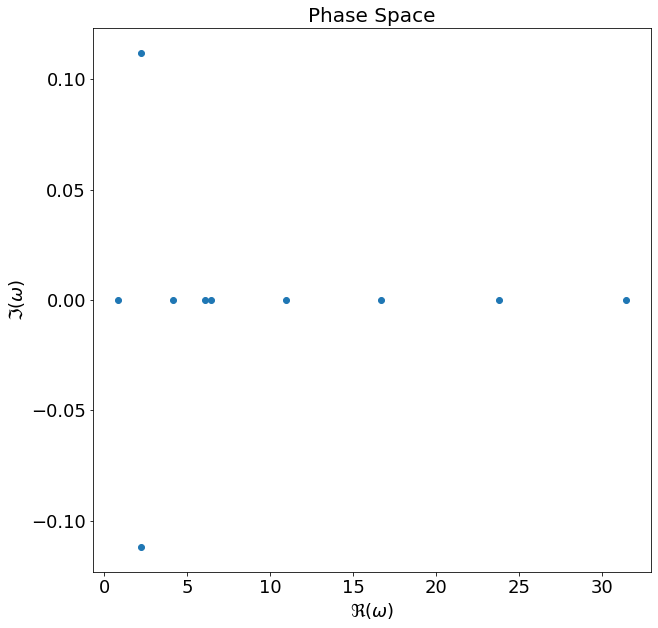

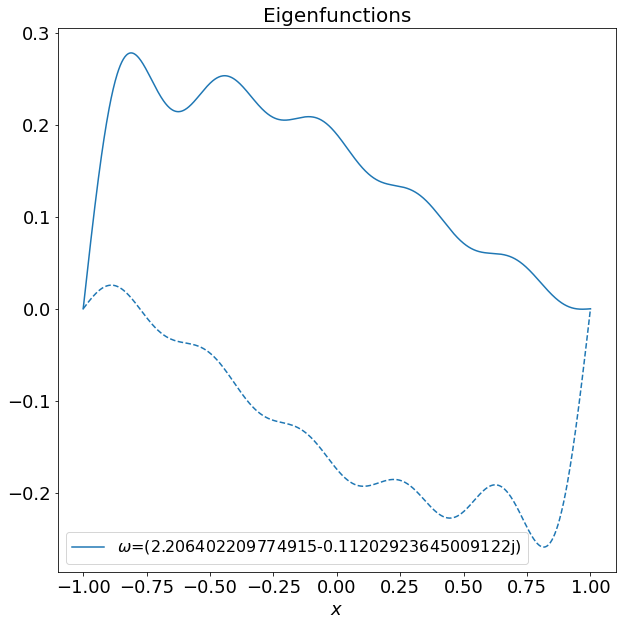

In [41]:
# finite-element + linear eigenvalue problem
A = np.block([[O,I],[A21,A22]])
omega,C = np.linalg.eig(A)

selection = (np.real(omega)>=0) #& (np.abs(np.imag(omega)) < 0.1)
C = C[:N,selection]
omega = omega[selection]

# sort
ind = np.argsort(np.real(omega))
omega = omega[ind]
C = C[:,ind]

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
i = 2
v = 0
for n in range(N):
    v += C[n,i]*u(x,n)
line = plt.plot(x, np.real(v), label=f"$\omega$={omega[i]}")
plt.plot(x, np.imag(v), '--', color=line[0]._color)
plt.xlabel("$x$")
plt.title("Eigenfunctions")
plt.legend();

print(omega[:10])
print(-(1-v0**2)*np.pi/2*np.arange(10))

$$ \omega^2\tilde{v} + 2i\omega v_0\tilde{v}' + (1-v_0^2)\tilde{v}'' = 0 $$

Let $ \tilde{v} = \sum_{n=1}^{N} a_n\sin(\frac{n\pi}{2}(x+1)) $. Using this, the equation becomes

$$ \left(\delta_{jk}\omega^2 + 2iv_0 mod(j-k,2)\left( 2\frac{jk}{j^2-k^2} \right)\omega - (1-v_0^2)\left(\frac{j\pi}{2}\right)^2\delta_{jk} \right)\mathbf{a} = \mathbf{0} $$

In [55]:
N = 30
L = 2
x0 = -1
psi = lambda x,n: np.sqrt(2/L)*np.sin(n*np.pi/L*(x-x0))


v0 = 0.5
O = np.zeros((N,N), dtype=complex)
I = np.eye(N,dtype=complex)
A21 = np.zeros((N,N), dtype=complex)
A22 = np.zeros((N,N), dtype=complex)

for i in range(1,N+1):
    for j in range(1,N+1):
        if i==j:
            A21[i-1,j-1] = -(1-v0**2)*(i*np.pi/2)**2
            
        if (i-j)%2 != 0:
            A22[i-1,j-1] = 2j*v0 * (4/L*i*j/(np.pi*(i**2-j**2)))

[2.24989404e-15 +4.15173974j 2.84000076e-15 -1.38391946j
 4.42166661e-15 +1.38391946j 4.83199469e-15 -6.91954695j
 5.38271222e-15 -2.76783255j 1.12050274e-14 +5.5356027j
 1.61543274e-14 -4.15173974j 1.71348148e-14 +8.30309053j
 4.22764648e-14+12.45995363j 4.40242859e-14 -9.68776495j]
[ -0.          -1.17809725  -2.35619449  -3.53429174  -4.71238898
  -5.89048623  -7.06858347  -8.24668072  -9.42477796 -10.60287521]


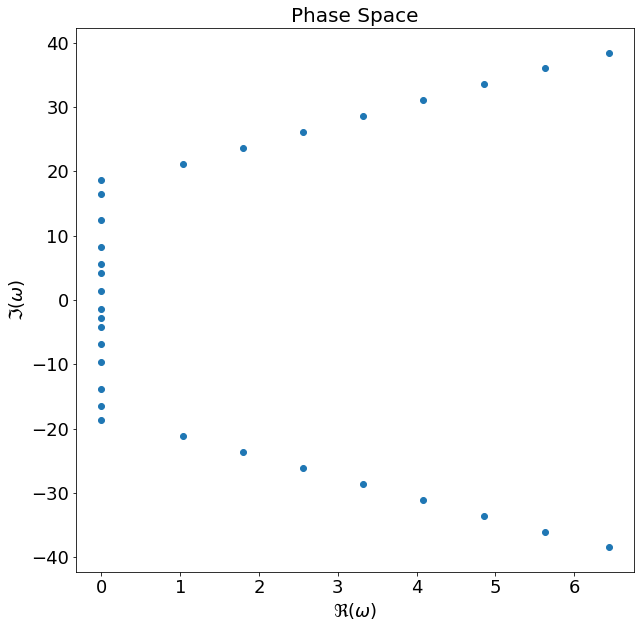

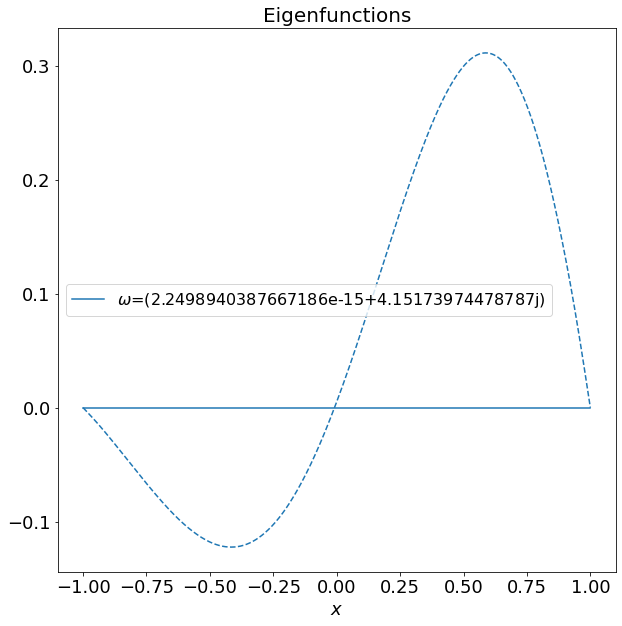

In [56]:
# finite-element + linear eigenvalue problem
A = np.block([[O,I],[A21,A22]])
omega,C = np.linalg.eig(A)

selection = (np.real(omega)>=0) #& (np.abs(np.imag(omega)) < 0.1)
C = C[:N,selection]
omega = omega[selection]

# sort
ind = np.argsort(np.real(omega))
omega = omega[ind]
C = C[:,ind]

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
i = 0
v = 0
for n in range(N):
    v += C[n,i]*psi(x,n)
line = plt.plot(x, np.real(v), label=f"$\omega$={omega[i]}")
plt.plot(x, np.imag(v), '--', color=line[0]._color)
plt.xlabel("$x$")
plt.title("Eigenfunctions")
plt.legend();

print(omega[:10])
print(-(1-v0**2)*np.pi/2*np.arange(10))